In [1]:
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


split data:

In [2]:


# Load the dataset
joined_df = pd.read_csv(r"E:\Nieuw dataset\Joined trends\joined_trend_sales.csv")

# Perform 80/20 split
split_index = int(0.8 * len(joined_df))
train_df = joined_df.iloc[:split_index].copy()
test_df = joined_df.iloc[split_index:].copy()

# Add a column to indicate train/test set
train_df['Set'] = 'Train'
test_df['Set'] = 'Test'

# Define separate output paths for train and test sets
train_output_path = r"E:\Nieuw dataset\Joined trends\train_trend.csv"
test_output_path = r"E:\Nieuw dataset\Joined trends\test_trend.csv"

# Save each DataFrame to its own CSV
train_df.to_csv(train_output_path, index=False)
test_df.to_csv(test_output_path, index=False)


Corrolation matrix and clustercloud

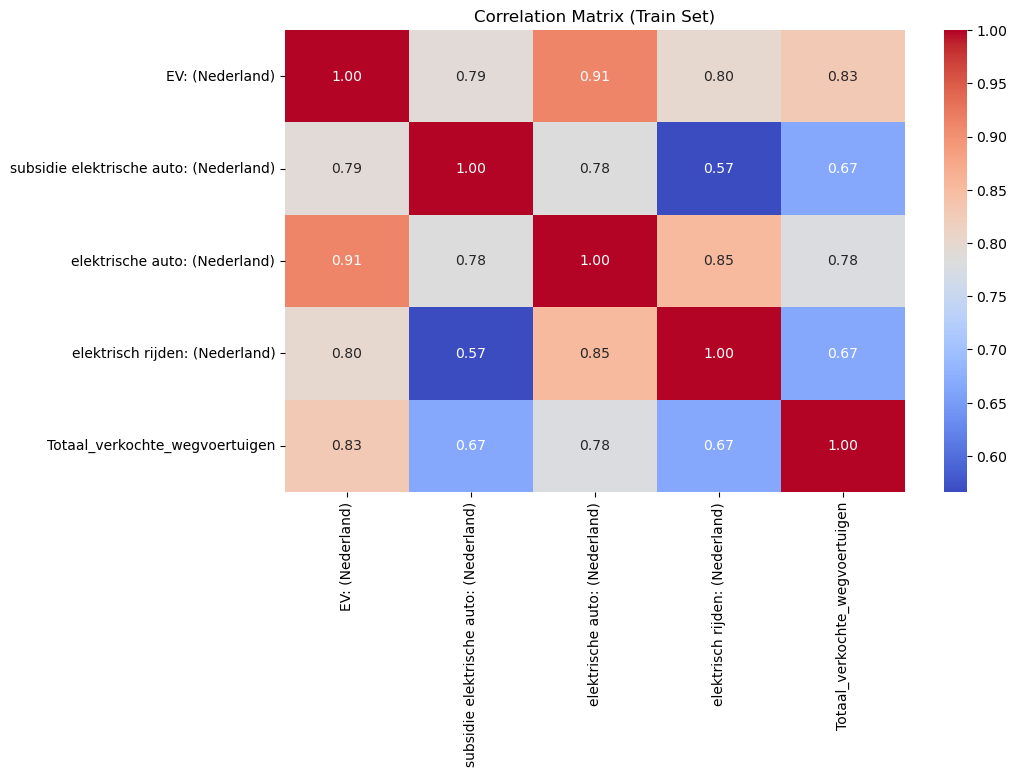

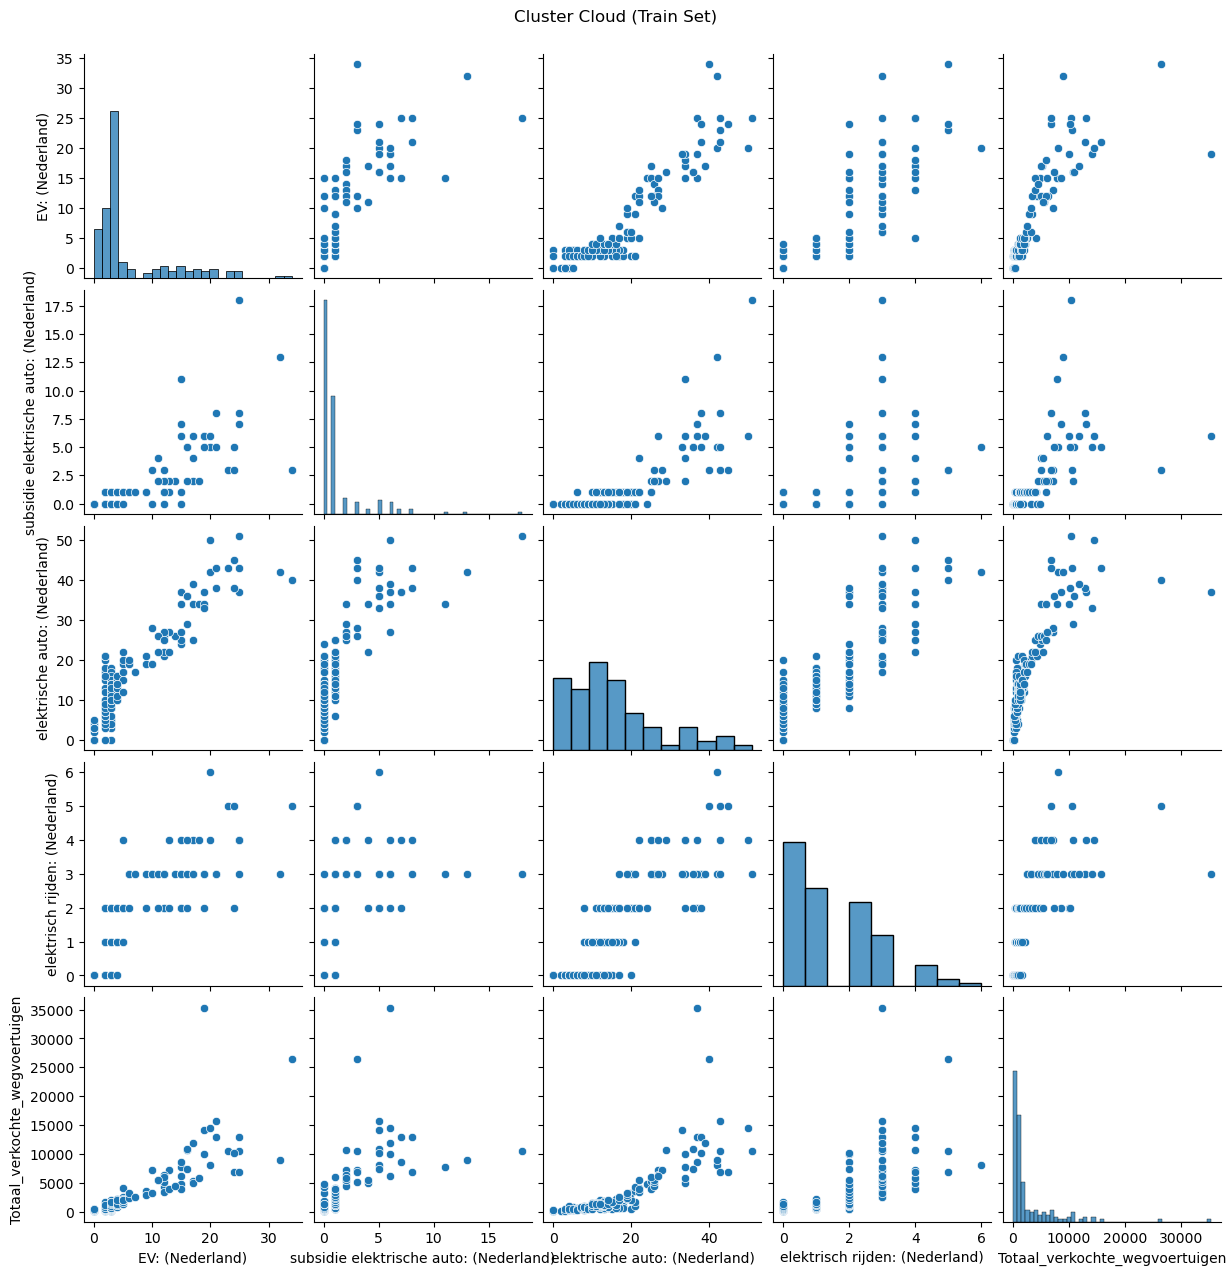

In [3]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 6))
corr = train_df.drop(columns=['Periode', 'Set']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Train Set)')
plt.show()

# Cluster cloud (pairplot)
sns.pairplot(train_df.drop(columns=['Periode', 'Set']))
plt.suptitle('Cluster Cloud (Train Set)', y=1.02)
plt.show()

Maand 2018-09-01 00:00:00: Voorspeld=4314.87, Werkelijk=4841.00, MAE=526.13
Maand 2018-10-01 00:00:00: Voorspeld=4451.04, Werkelijk=3919.00, MAE=532.04
Maand 2018-11-01 00:00:00: Voorspeld=3919.07, Werkelijk=5271.00, MAE=1351.93
Maand 2018-12-01 00:00:00: Voorspeld=4471.65, Werkelijk=7999.00, MAE=3527.35
Maand 2019-01-01 00:00:00: Voorspeld=4741.99, Werkelijk=5037.00, MAE=295.01
Maand 2019-02-01 00:00:00: Voorspeld=3727.64, Werkelijk=4418.00, MAE=690.36
Maand 2019-03-01 00:00:00: Voorspeld=3917.34, Werkelijk=7219.00, MAE=3301.66
Maand 2019-04-01 00:00:00: Voorspeld=4798.81, Werkelijk=5074.00, MAE=275.19
Maand 2019-05-01 00:00:00: Voorspeld=7054.06, Werkelijk=6291.00, MAE=763.06
Maand 2019-06-01 00:00:00: Voorspeld=6312.74, Werkelijk=7221.00, MAE=908.26
Maand 2019-07-01 00:00:00: Voorspeld=4791.43, Werkelijk=5544.00, MAE=752.57
Maand 2019-08-01 00:00:00: Voorspeld=3919.25, Werkelijk=5986.00, MAE=2066.75
Maand 2019-09-01 00:00:00: Voorspeld=5959.90, Werkelijk=10695.00, MAE=4735.10
Maand 

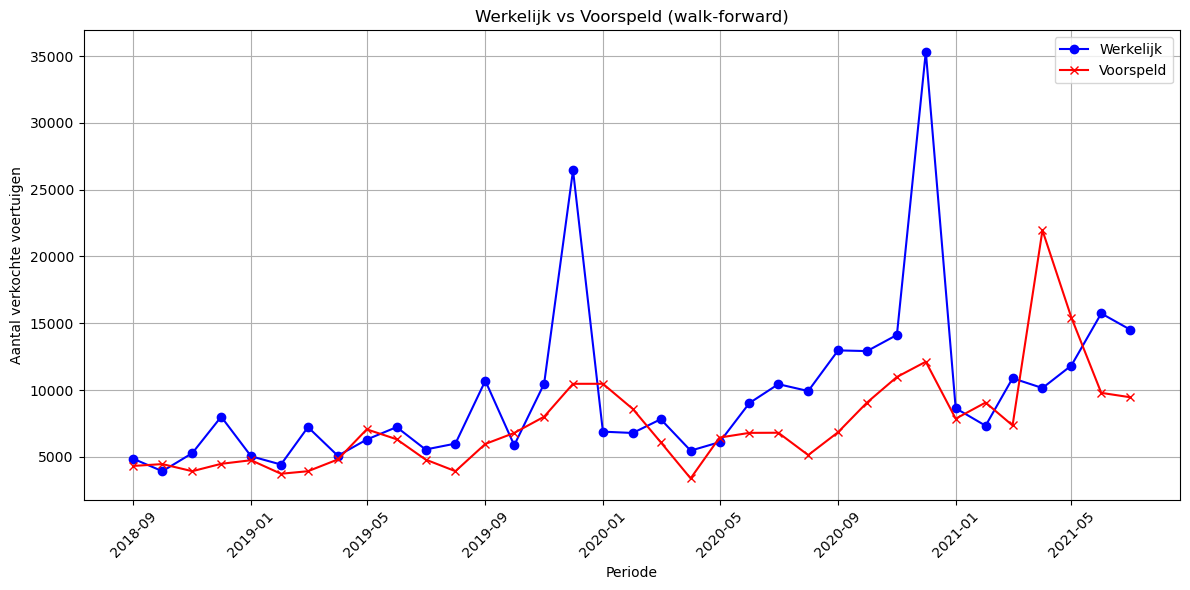

([4314.866,
  4451.045,
  3919.0671,
  4471.649,
  4741.986,
  3727.6362,
  3917.337,
  4798.805,
  7054.061,
  6312.737,
  4791.4297,
  3919.2524,
  5959.9,
  6784.499,
  7998.189,
  10464.543,
  10465.614,
  8581.539,
  6086.7876,
  3380.5872,
  6437.5435,
  6789.974,
  6799.1777,
  5125.6685,
  6840.61,
  9060.6045,
  10976.219,
  12120.627,
  7851.7603,
  9061.956,
  7345.629,
  21962.598,
  15430.132,
  9786.276,
  9458.393],
 3661.20791015625)

In [5]:


# Define walk-forward cross-validation function
def xgboost_forecast(trainX, trainy, valx):
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    return model.predict(np.array([valx]))[0]

def walk_forward_prediction(df_train_full, target_col='Totaal_verkochte_wegvoertuigen'):
    # Use all columns except 'Periode', 'Set', and the target as features
    feature_cols = [col for col in df_train_full.columns if col not in ['Periode', 'Set', target_col]]
    
    # Use last 20% of train set as internal validation set for walk-forward
    split_idx = int(len(df_train_full) * 0.8)
    df_train = df_train_full.iloc[:split_idx].copy()
    df_val = df_train_full.iloc[split_idx:].copy()

    trainX = df_train[feature_cols].values
    trainy = df_train[target_col].values
    valX = df_val[feature_cols].values
    valy = df_val[target_col].values

    predictions = []
    monthly_mae = []

    for i in range(len(valX)):
        valx = valX[i]
        yhat = xgboost_forecast(trainX, trainy, valx)
        predictions.append(yhat)

        month_mae = mean_absolute_error([valy[i]], [yhat])
        monthly_mae.append(month_mae)
        print(f"Maand {df_val['Periode'].iloc[i]}: Voorspeld={yhat:.2f}, Werkelijk={valy[i]:.2f}, MAE={month_mae:.2f}")

        new_row = df_val.iloc[i:i+1].copy()
        df_train = pd.concat([df_train, new_row], ignore_index=True)
        trainX = df_train[feature_cols].values
        trainy = df_train[target_col].values

    overall_mae = mean_absolute_error(valy, predictions)
    print(f"\nOverall MAE op validatieset: {overall_mae:.2f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(df_val['Periode'], valy, label='Werkelijk', marker='o', color='blue')
    plt.plot(df_val['Periode'], predictions, label='Voorspeld', marker='x', color='red')
    plt.title('Werkelijk vs Voorspeld (walk-forward)')
    plt.xlabel('Periode')
    plt.ylabel('Aantal verkochte voertuigen')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return predictions, overall_mae

# Run the walk-forward cross-validation
walk_forward_prediction(train_df)


In [7]:


# Define features and target
target_col = 'Totaal_verkochte_wegvoertuigen'
feature_cols = [col for col in df_full.columns if col not in ['Periode', 'Set', target_col]]

X = df_full[feature_cols].values
y = df_full[target_col].values
periods = df_full['Periode'].values

# TimeSeriesSplit with 5 folds
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    periods_test = periods[test_idx]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    fold_mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(fold_mae)

    print(f"Fold {fold}: MAE = {fold_mae:.2f}")

# Report average MAE
avg_mae = np.mean(mae_scores)
avg_mae


Fold 1: MAE = 267.58
Fold 2: MAE = 295.64
Fold 3: MAE = 514.45
Fold 4: MAE = 1831.79
Fold 5: MAE = 5086.52


1599.1935668945312